<a href="https://colab.research.google.com/github/lianghhhhh/ML_hw3_cnn/blob/main/semi_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3 - Convolutional Neural Network**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

In [ ]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下載資料集
!unzip food-11.zip # 解壓縮

In [14]:
# Import需要的套件
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time

#Read image
利用 OpenCV (cv2) 讀入照片並存放在 numpy array 中

In [15]:
def readfile(path, label):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [16]:
# 分別將 training set、validation set、testing set 用 readfile 函式讀進來
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [17]:
# training 時做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization)
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [18]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

#test -> unlabeled -> do semi
unlabeled_x = test_x
unlabeled_set = ImgDataset(test_x, transform=test_transform)

# Model

In [19]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

define unlabeled function for doing semi-supervised learning

In [21]:
def get_pseudo_labels(dataset, model, threshold=0.65):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()

    prediction = []
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            pred = model(data.cuda())
            label = np.argmax(pred.cpu().data.numpy(), axis=1)
            for y in label:
                prediction.append(y)

    # # Turn off the eval mode.
    model.train()
    return prediction

# Training

使用 training set 訓練，並使用 validation set 尋找好的參數

In [22]:
model = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 80

train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []
best_acc = 0.0

do_semi = True
did_semi = False

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    if do_semi and best_acc > 0.7:
        print("do_semi")
        did_semi = True
        labeled_y = get_pseudo_labels(unlabeled_set, model)
        x = np.concatenate((train_x, unlabeled_x), axis=0)
        y = np.concatenate((train_y, labeled_y), axis=0)
        semi_train_set = ImgDataset(x, y, train_transform)
        train_loader = DataLoader(semi_train_set, batch_size=batch_size, shuffle=True)

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()

        #將結果 print 出來
        if did_semi:
            print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
             (epoch + 1, num_epoch, time.time()-epoch_start_time, \
              train_acc/semi_train_set.__len__(), train_loss/semi_train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
            train_loss_record.append(train_loss/semi_train_set.__len__())
            valid_loss_record.append(val_loss/val_set.__len__())
            train_acc_record.append(train_acc/semi_train_set.__len__())
            valid_acc_record.append(val_acc/val_set.__len__())

        else:
            print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
             (epoch + 1, num_epoch, time.time()-epoch_start_time, \
              train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))
            train_loss_record.append(train_loss/train_set.__len__())
            valid_loss_record.append(val_loss/val_set.__len__())
            train_acc_record.append(train_acc/train_set.__len__())
            valid_acc_record.append(val_acc/val_set.__len__())


    if (val_acc/val_set.__len__()) > best_acc:
        best_acc = (val_acc/val_set.__len__())


[001/080] 25.05 sec(s) Train Acc: 0.221873 Loss: 0.018291 | Val Acc: 0.246356 loss: 0.017021
[002/080] 25.28 sec(s) Train Acc: 0.313602 Loss: 0.015276 | Val Acc: 0.309621 loss: 0.016018
[003/080] 25.44 sec(s) Train Acc: 0.380904 Loss: 0.013948 | Val Acc: 0.389504 loss: 0.013769
[004/080] 25.30 sec(s) Train Acc: 0.430266 Loss: 0.012848 | Val Acc: 0.406706 loss: 0.013814
[005/080] 25.33 sec(s) Train Acc: 0.468782 Loss: 0.011965 | Val Acc: 0.362391 loss: 0.015506
[006/080] 25.06 sec(s) Train Acc: 0.512771 Loss: 0.011077 | Val Acc: 0.418950 loss: 0.014203
[007/080] 24.99 sec(s) Train Acc: 0.530509 Loss: 0.010550 | Val Acc: 0.501166 loss: 0.011651
[008/080] 25.17 sec(s) Train Acc: 0.552504 Loss: 0.009968 | Val Acc: 0.512828 loss: 0.011908
[009/080] 25.18 sec(s) Train Acc: 0.595783 Loss: 0.009164 | Val Acc: 0.452478 loss: 0.013926
[010/080] 25.19 sec(s) Train Acc: 0.602574 Loss: 0.009065 | Val Acc: 0.494752 loss: 0.012179
[011/080] 25.24 sec(s) Train Acc: 0.629333 Loss: 0.008515 | Val Acc: 0

Visualize data

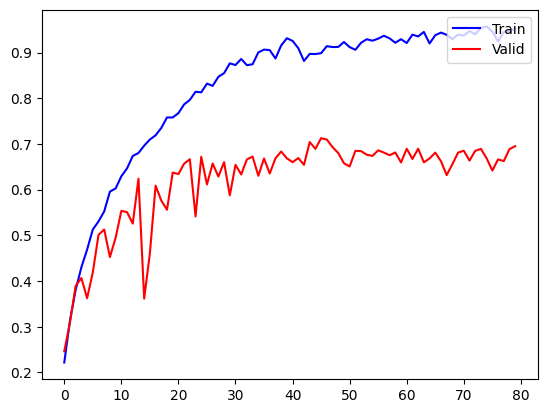

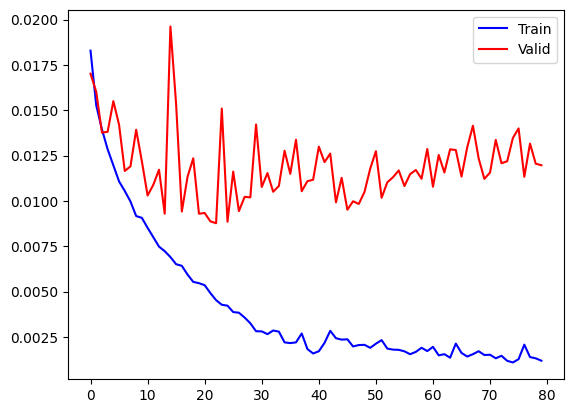

In [23]:
import matplotlib.pyplot as plt

x = np.arange(len(train_acc_record))
plt.plot(x, train_acc_record, color="blue", label="Train")
plt.plot(x, valid_acc_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.show()


x = np.arange(len(train_loss_record))
plt.plot(x, train_loss_record, color="blue", label="Train")
plt.plot(x, valid_loss_record, color="red", label="Valid")
plt.legend(loc="upper right")
plt.show()

# Create requirements.txt

In [24]:
pip freeze > requirements.txt